# 02-ContaminatedRegionsVisualization

* Original version by Federico Villadiego Forero
* Updates by Veronique Petit

## 0 Packages and data

In [1]:
path='G:/Shared drives/BeStarsMiMeS/UpdatedFiles/' #Patrick's google file stream path

In [2]:
import specpolFlow as pol
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as const
import os
import copy

In [3]:
import pandas as pd
sheet_id = '1M6y1Wnsrc-w5FjUMfKaSFa_-foIDAaMe8W4lYNWnWyk'
sheet_name = 'Stars'
url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}'
StarData=pd.read_csv(url)

sheet_name = 'Observations'
url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}'
Observations=pd.read_csv(url)

## 1. Functions to read the synthetic models, and to splice and merge echelle data along orders. 

In [4]:
#note: included within specpolFlow
def read_disk(file):
  '''
  Read a synthetic spectrum from a s3div output

  :param file: The filename
  :rtype: wave, flux -- the wavelength in nm, and the normalized flux. 
  '''
  with open(file) as f:
    lines = f.readlines()
  # number of atomic lines in the header of the file
  natomic = int(lines[0].split(sep='-')[0])
  nwave=int(lines[natomic+1].split()[0])
  data = np.genfromtxt(lines[natomic+2:natomic+1+nwave])
  return(data[:,0]/10.0, data[:,1])

def split_order(data):
  '''
  Split an observation object into a list of observation objects with one order per item
  '''
  # one order is where the wavelength backtracks. 
  ind = np.where((data.wl[1:]-data.wl[0:-1]) < 0)[0]
  norder = ind.size+1
  ind = np.append(-1,ind)
  ind = np.append(ind,data.wl.size)
  print('{} orders'.format(norder))

  list_order=[]
  for i in range(0,norder):
    list_order.append(data[ind[i]+1:ind[i+1]])
 
  return(list_order)
  
def splice_order(list_order):
  '''
  Concatenate a list of observation objects (usually split into a list of orders by split_order function). Note: it does not merge the orders overlaps.
  '''
  wl = np.array([])
  specI = np.array([])
  specV = np.array([])
  specN1 = np.array([])
  specN2 = np.array([])
  specSig = np.array([])
  for item in list_order:
    wl=np.append(wl,item.wl)
    specI=np.append(specI,item.specI)
    specV=np.append(specV,item.specV)
    specN1=np.append(specN1,item.specN1)
    specN2=np.append(specN2,item.specN2)
    specSig=np.append(specSig, item.specSig)
  return(pol.Spectrum(wl, specI, specV, specN1, specN2, specSig, header=list_order[0].header))

def rshift(wave, radvel):
  '''
  Shift a spectrum in terms of radial velocity. The wavelength array and the velocity arrays must be defied as astropy units quantities.
  The new wavelength array is returned in the same units as the initial wavelength array. 
  '''
  return( (wave + wave*radvel/const.c).to(wave.unit).value )


## 2. Load in the region list

In [5]:
#Regions

sheet_id='19lS0Xg-2ZUs0ps8jZ-JM3pR1YIuC_lWvRMpFAM5VUYI'
sheet_name = 'WLRegions'
url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}'
WLRegions=pd.read_csv(url)
WLRegions

,WLStart,WLFinish,Type
0,587.500000,592.000000,Telluric
1,627.500000,632.500000,Telluric
2,684.000000,705.300000,Telluric
3,717.000000,735.000000,Telluric
4,757.000000,771.000000,Telluric
5,790.000000,794.000000,Telluric
6,809.000000,990.000000,Telluric
7,360.000000,392.000000,Hjump
8,654.112333,658.487667,Halpha
9,484.519533,487.760467,Hbeta


## 3. Illustration figure

37 orders


C:\Users\pjsta\AppData\Local\Temp\ipykernel_25236\4167633283.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1,1, figsize=(10,2))


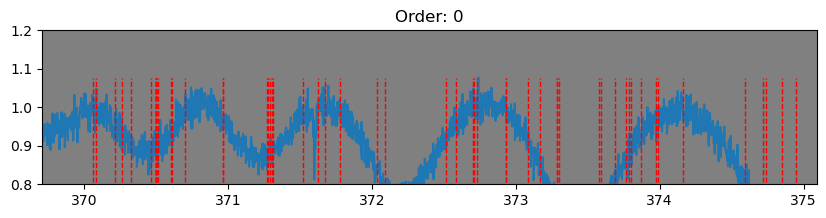

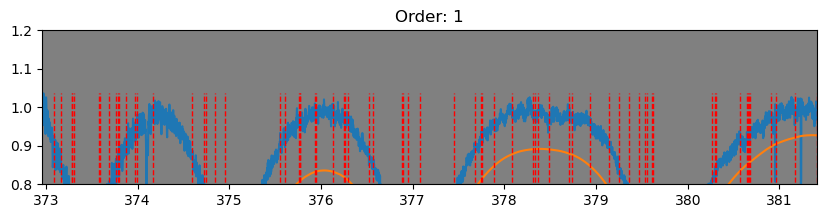

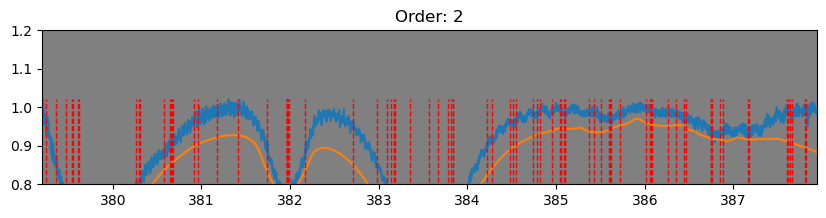

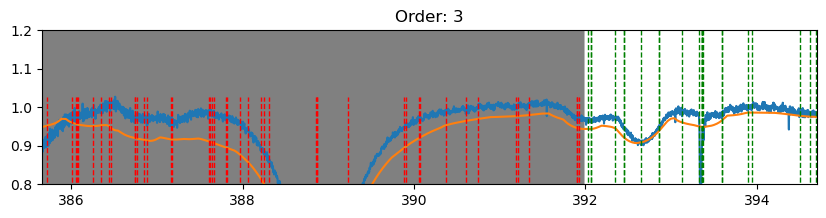

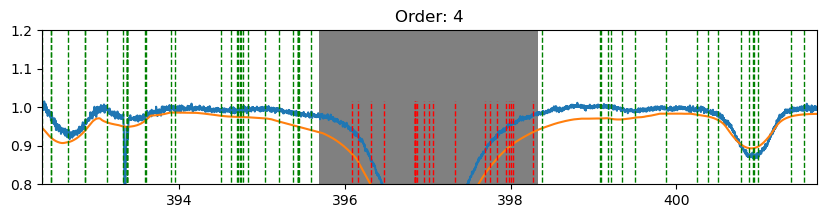

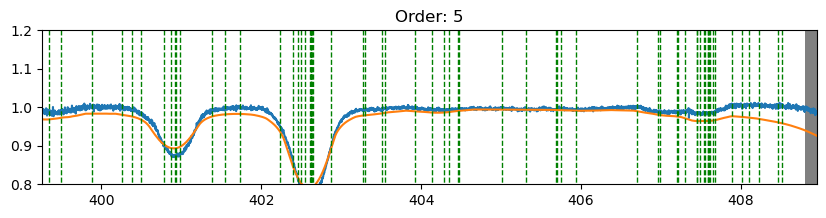

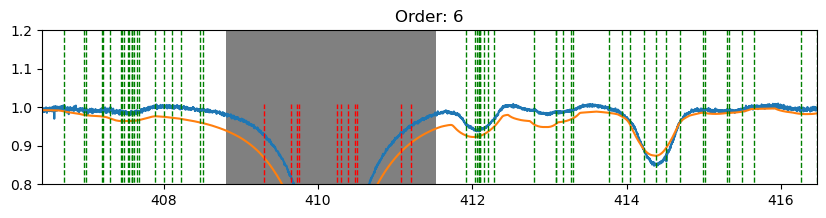

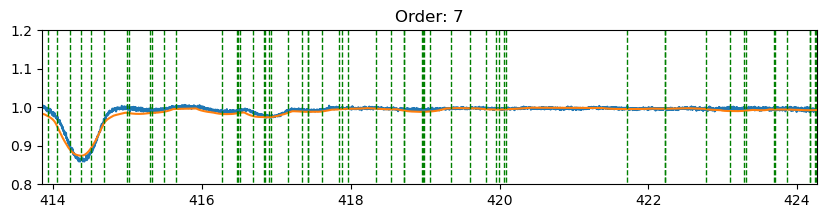

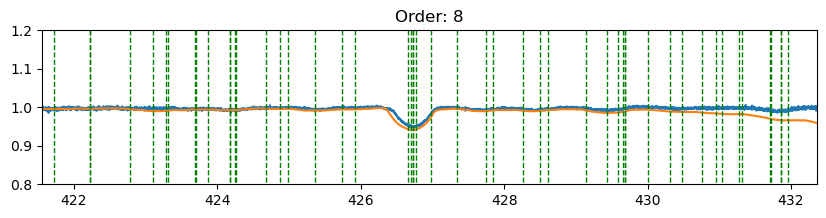

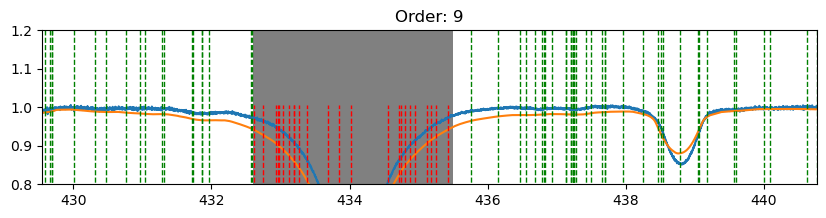

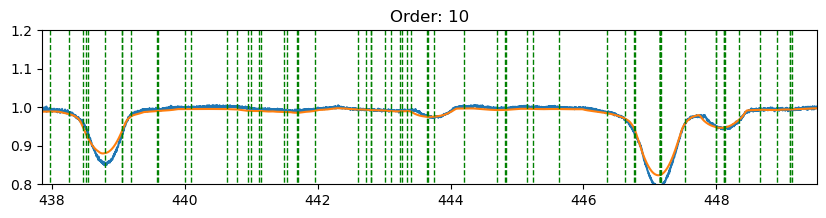

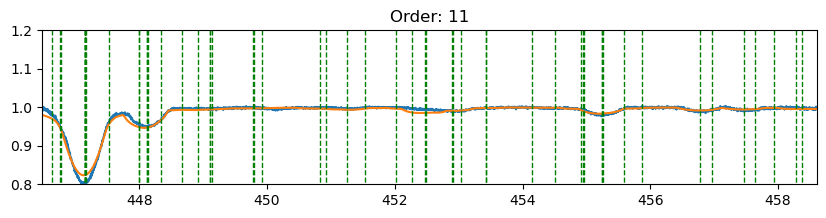

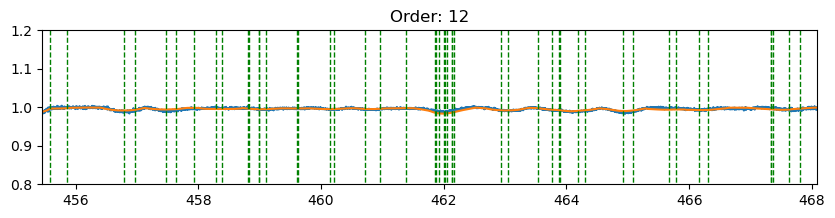

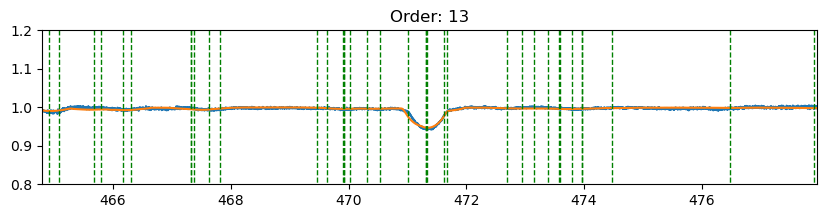

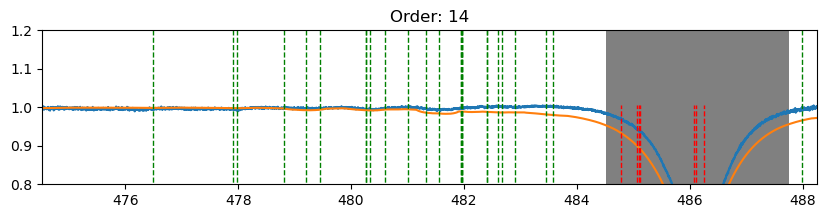

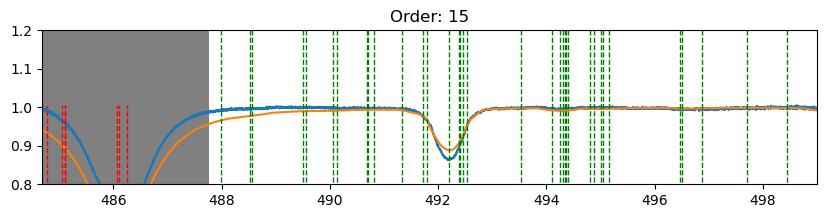

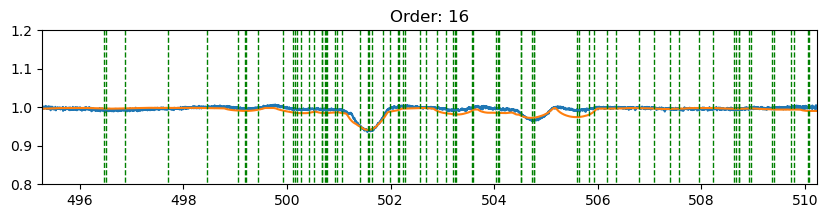

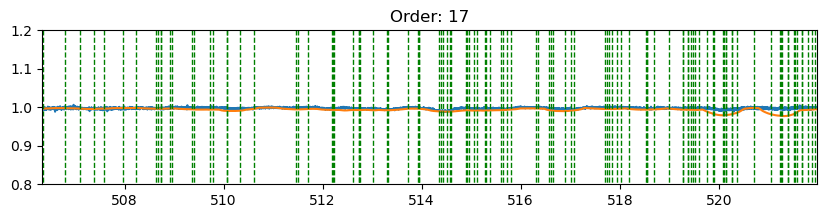

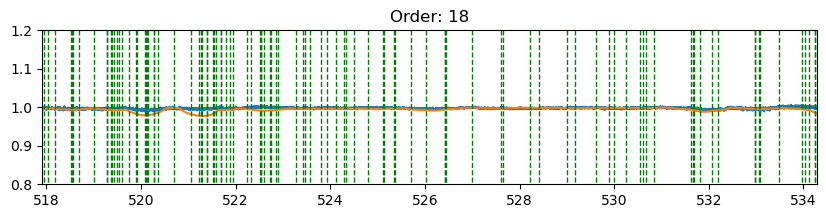

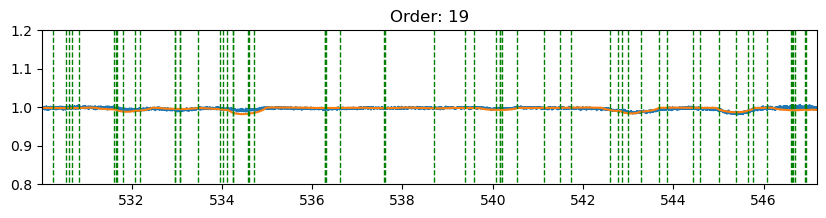

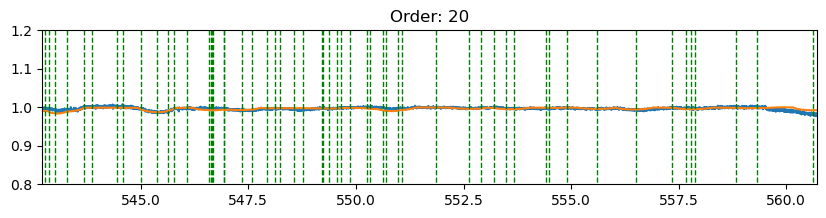

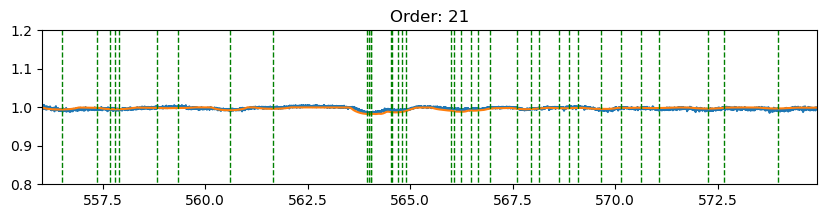

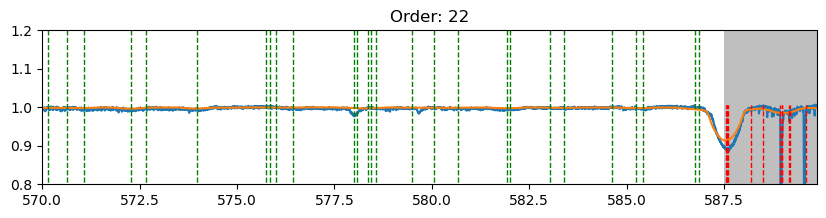

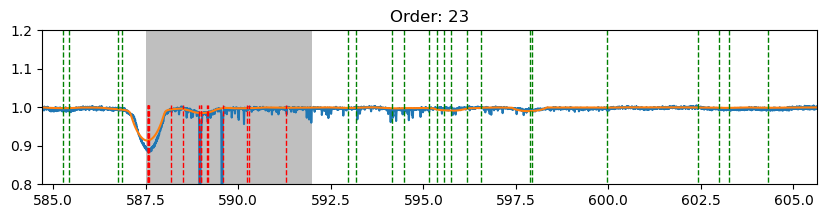

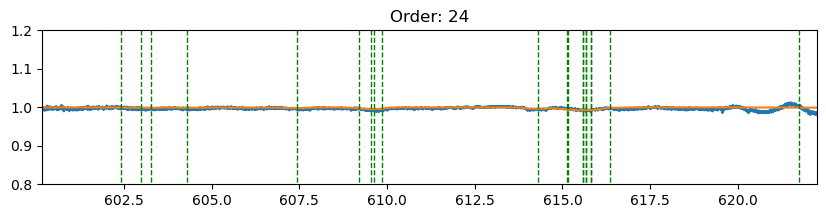

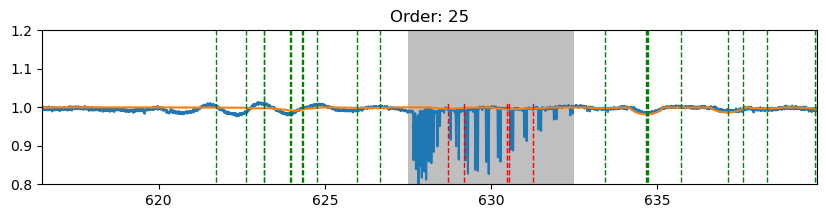

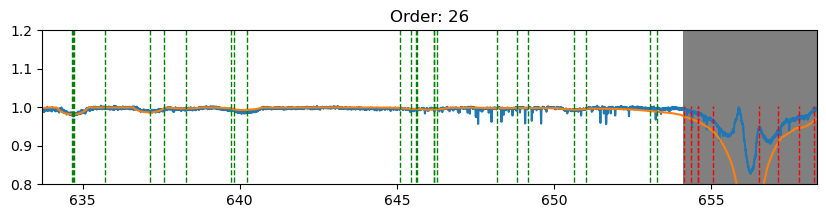

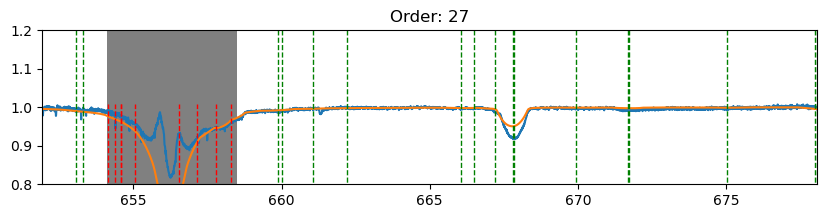

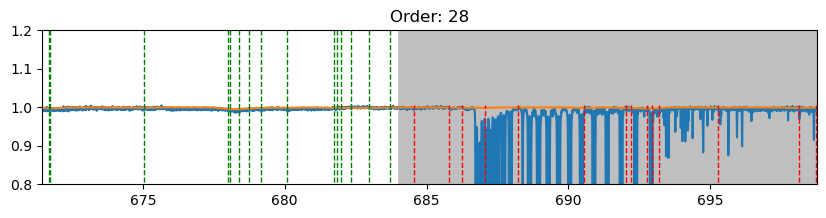

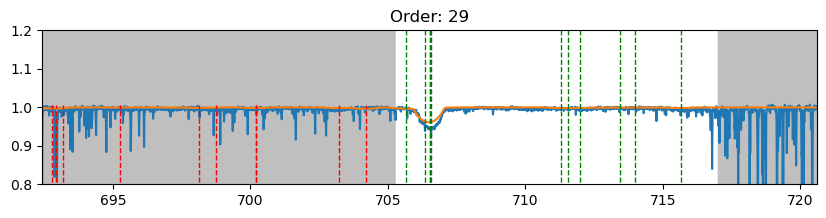

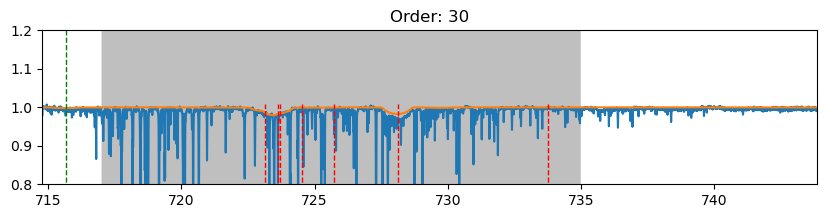

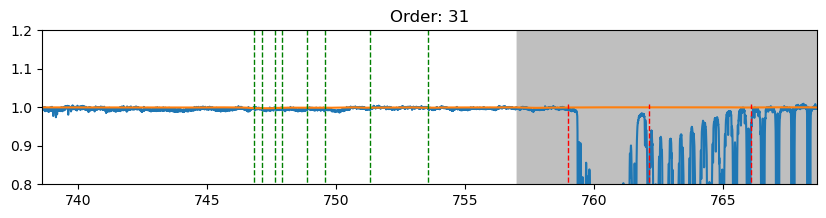

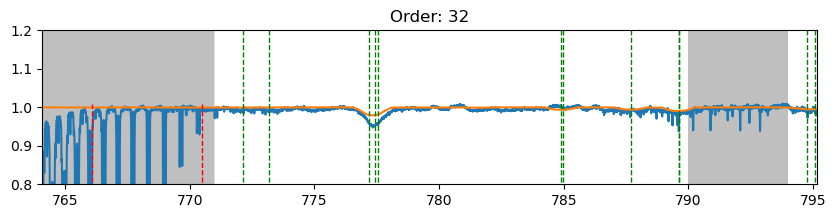

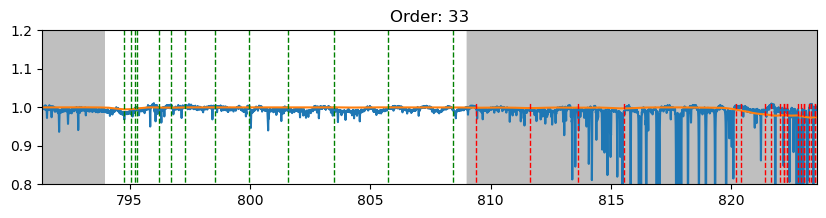

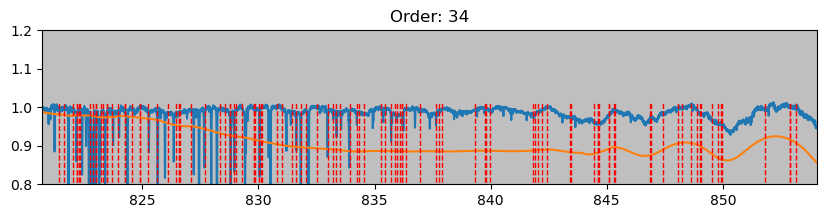

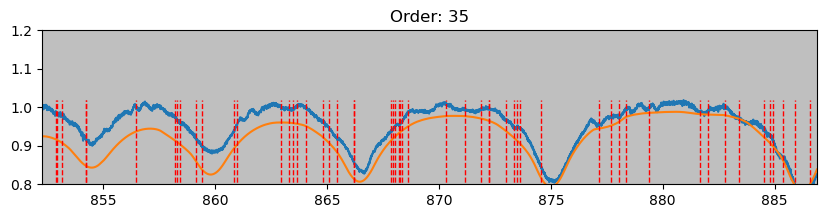

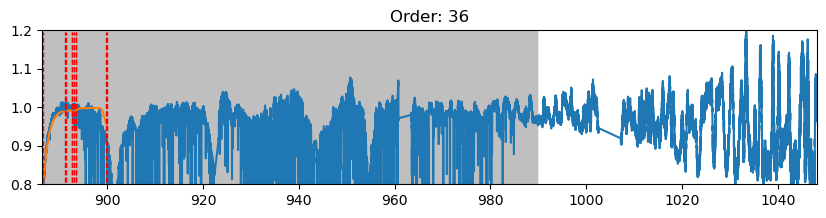

In [9]:
#note: included within specpolFlow
#################
#################
# Pick a star and observation number
hd = 'hd189687'
o = 1
##################
##################

# retieve that row from the StarData spreadsheet
star = StarData[StarData["Name"]==hd]

# retieve the observation list
ob = Observations[Observations["Name"] == hd]
# retrieve the specified observation row
obs = ob[ob["Unnamed: 2"]==o]
#star
#obs


# reading the observed spectrum
file_obs = '{}00-InputMaterial/NormalizedSpectra/{}_{}.s'.format(path,hd, o)
data_obs = pol.read_spectrum(file_obs)
# splitting the observed spectrum by order
list_order = split_order(data_obs)

# reading the model spectrum
file_mod = '{}01-Synth-calculations/Synth-diskint-spectra/{}.dsk'.format(path,hd)
mod_wave, mod_flux = read_disk(file_mod)

# shifting the model spectrum for its radial velocity
# (note the rshift function asks for numpy unit quantities)
mod_wave_shift = rshift(mod_wave*u.nm, float(obs["Unnamed: 11"])*u.km/u.s)

# read in the mask 
file_mask='{}02-Mask-calculations/MaskCleaning/depth0.02_tellClean/{}_depth0.02.mask'.format(path,star["ModelCode"].item().upper())
mask = pol.read_mask(fname=file_mask)

mask_used = mask.wl[mask.iuse==1]
mask_not_used = mask.wl[mask.iuse==0]


for i, order in enumerate(list_order):
  fig, ax = plt.subplots(1,1, figsize=(10,2))
  #Setting limits to axes
  ax.set_xlim([order.wl[0],order.wl[-1]])
  ax.set_ylim(0.8,1.2)
  ax.set_title('Order: {}'.format(i))

  ## Plotting the spectrum
  p = ax.plot(order.wl, order.specI, label='Observation')
  ## plotting the synthetic model
  p = ax.plot(mod_wave_shift, mod_flux, label='Model')

  # plotting the lines from the masks
  p = ax.vlines(x=mask_used, ymin=0, ymax=1.2,color='green',linestyle='--',lw=1)
  p = ax.vlines(x=mask_not_used,ymin=0, ymax=np.max(order.specI),color='r',linestyle='--',lw=1)


  ## Plotting the excluded regions in shaded grey
  for i in range(0,np.shape(WLRegions)[0]):
    if WLRegions.loc[i,'Type']=='Telluric':
      color = '0.75'
    else:
      color = '0.5'
    Xr = np.arange(WLRegions.loc[i,'WLStart'],WLRegions.loc[i,'WLFinish'],0.01)
    p = ax.fill_between(Xr,y1=0,y2=1.2,facecolor =color)